# 神经网络的梯度计算

在这里我们实现一个单层感知机的输入和输出的模拟

$E = \frac{1}{2}(O_0^1-t)^2$

![9](./assets/9.png)

单层的感知节点, 我们对每一个节点的求导公式就是

![10](./assets/10.png)


In [13]:
import torch
from torch.nn import functional as F


In [14]:
# 定义10个输入
x = torch.rand(1, 10)
# 定义10个权重
w = torch.rand(1, 10, requires_grad=True)

o = torch.sigmoid(w@x.t())  # 两个矩阵相乘, 计算输出的sigmoid, 输出应该是一个单一元素
print(o.shape)

# 第一个参数是实际值, 第二个是预测值
loss = F.mse_loss(torch.ones(1, 1), o)
print(loss.shape)

loss.backward()
print(w.grad)


torch.Size([1, 1])
torch.Size([])
tensor([[-1.5058e-03, -1.0079e-03, -1.3612e-03, -1.4961e-03, -1.6951e-04,
         -7.3136e-04, -9.3174e-05, -3.4033e-04, -3.2307e-04, -1.2967e-03]])


这里的w.grad就是我们所需要的$\Delta{w}$, 然后我们用$w - learningRate * \Delta{w}$就可以了

## 多层神经网络感知计算

![11](./assets/11.png)

![12](./assets/12.png)

In [15]:
# 定义输入
x = torch.randn(1, 10)
# 定义权重
w = torch.randn(2, 10, requires_grad=True)

# 计算sigmoid输出
o = torch.sigmoid(w@x.t())
print("sigmoid output: ", o.shape)  # [1,10] * [10,2]矩阵相乘, 应该输出2个元素

# 第一个是目标值, 第二个是预测值. 注意, loss依旧应该是一个单一的数值
# loss = F.mse_loss(torch.ones(1, 1), o) # 这样也可以, 符合broadcast规范, 自动将1复制两次
loss = F.mse_loss(torch.ones(2, 1), o)
print("loss:", loss)

# 梯度计算
loss.backward()

print(w.grad)


sigmoid output:  torch.Size([2, 1])
loss: tensor(0.1731, grad_fn=<MseLossBackward0>)
tensor([[-0.0471, -0.0435, -0.1516,  0.0274,  0.0339,  0.0778,  0.0022,  0.0551,
         -0.0389,  0.0633],
        [-0.0809, -0.0746, -0.2601,  0.0471,  0.0583,  0.1335,  0.0038,  0.0946,
         -0.0667,  0.1087]])


### 链式法则

多层神经网络的隐藏层


In [16]:


# 这里定义的都是单节点, 一个w1b1,一个w2b2, 输入一个x为1
x = torch.tensor(1.)
w1 = torch.tensor(2., requires_grad=True)
b1 = torch.tensor(1.)
w2 = torch.tensor(2., requires_grad=True)
b2 = torch.tensor(1.)

y1 = x * w1 + b1
y2 = y1 * w2 + b2

# 第一种方法求得x得到结果梯度
# 根据y2对y1进行求导, 也就是得到w2的梯度, 因为第二个函数中只有w2可以计算梯度
dy2_dy1 = torch.autograd.grad(y2, [y1], retain_graph=True)[0]
# 根据y1对w1进行求导, 得到的就是x
dy1_dw1 = torch.autograd.grad(y1, [w1], retain_graph=True)[0]

# 第二种方法, 使用链式法则得到结果梯度
dy2_dw1 = torch.autograd.grad(y2, [w1], retain_graph=True)[0]

# 验证一下通过两部
print(dy2_dy1*dy1_dw1)
print(dy2_dw1)


tensor(2.)
tensor(2.)


### 使用链式法则进行反向传播

多层感知

![13](./assets/13.png)

相对于第一层我们的error公式

![14](./assets/14.png)

最终得到的多层神经感知的求导公式, 然后将$\delta{k}$公式带入到公式中我们就得到了一个简化的梯度公式

![15](./assets/15.png)

最终我们可以通过信息获取一层一层的迭代得到最终的结果

![16](./assets/16.png)

### 性能优化问题

我们可以使用一个优化函数检测工具:

$f(x,y)=(x^2+y-11)^2+(x+y^2-7)^2$

![17](./assets/17.png)

这个函数有一个好处就是有4个最优解, 全都是0. 我们可以通过查看优化函数来计算是否可以的到最优解


x,y range: (120,) (120,)
X,Y maps: (120, 120) (120, 120)


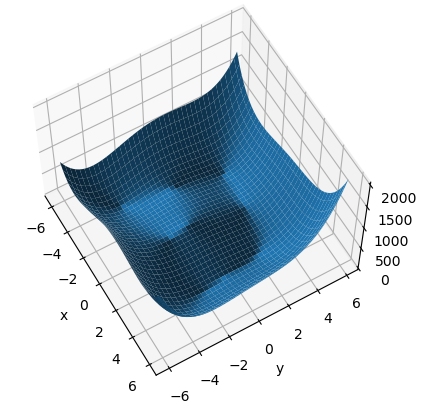

step 0: x = [-3.999000072479248, -0.0009999999310821295], f(x) = 146.0
step 2000: x = [-3.526559829711914, -2.5002429485321045], f(x) = 19.4503231048584
step 4000: x = [-3.777446746826172, -3.2777843475341797], f(x) = 0.0012130826944485307
step 6000: x = [-3.7793045043945312, -3.283174753189087], f(x) = 5.636138666886836e-09
step 8000: x = [-3.779308319091797, -3.28318190574646], f(x) = 7.248672773130238e-10
step 10000: x = [-3.7793095111846924, -3.28318452835083], f(x) = 8.822098607197404e-11
step 12000: x = [-3.7793102264404297, -3.2831854820251465], f(x) = 8.185452315956354e-12
step 14000: x = [-3.7793102264404297, -3.2831859588623047], f(x) = 0.0
step 16000: x = [-3.7793102264404297, -3.2831859588623047], f(x) = 0.0
step 18000: x = [-3.7793102264404297, -3.2831859588623047], f(x) = 0.0


In [18]:
import numpy as np
from matplotlib import pyplot as plt
import torch


# 平面上每一个点都是一个点, x就是横坐标, y就是纵坐标
def himmelblau(x):
    return (x[0] ** 2 + x[1] - 11) ** 2 + (x[0] + x[1] ** 2 - 7) ** 2


# 我们直接对其进行绘图, x和y的值都输入进来, 然后得到一个图像.
x = np.arange(-6, 6, 0.1)
y = np.arange(-6, 6, 0.1)
print('x,y range:', x.shape, y.shape)
X, Y = np.meshgrid(x, y)
print('X,Y maps:', X.shape, Y.shape)
Z = himmelblau([X, Y])

fig = plt.figure('himmelblau')
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z)
ax.view_init(60, -30)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()


# 我们现在进行预测
# 我们可以随机选择几个初始化点: [1., 0.], [-4, 0.], [4, 0.]
x = torch.tensor([-4., 0.], requires_grad=True)  # 创建一个初始化点, 需要进行梯度信息更新
# 引入优化器
# 优化器的优化目标就是x, 学习率0.001
# x' = x - 0.001 dx
# y' = y - 0.001 dy
optimizer = torch.optim.Adam([x], lr=1e-3)
for step in range(20000):
    pred = himmelblau(x)  # 进行计算
    optimizer.zero_grad()  # 梯度清零
    pred.backward()  # 反向传播#
    optimizer.step()  # 优化梯度

    if step % 2000 == 0:
        print('step {}: x = {}, f(x) = {}'
              .format(step, x.tolist(), pred.item()))
